In [1]:
import copy
import os
import pickle
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset

from utils.options import args_parser
from utils.train_utils import get_data, get_model
from models.Update import DatasetSplit
from models.test import test_img_local, test_img_local_all, test_img_global

import pdb
import easydict

import sys

import random



# Seed
torch.manual_seed(1)#args.running_idx=args.seed
torch.cuda.manual_seed(1)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False
np.random.seed(1)
random.seed(1)


In [2]:
def record_net_data_stats(net_dataidx_map, all_targets):
    net_cls_counts = {}#각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(all_targets[dataidx], return_counts=True)#전체 train data 중에 net_i번째 client가 가지고 있는 data가 어떤 label을 가지고 있는지의 정보가 unq, unq의 각 element가 몇개 들어있는지 기재하는게 unq_count이다!!
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}#tmp에는 unq가 key unq_count가 value가 되게 기재!!
        net_cls_counts[net_i] = tmp
    return net_cls_counts #각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

In [3]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for frac in [0.1]:
    for local_ep in [15]:
        for local_upt_part, aggr_part in [('full', 'full')]:
            args = easydict.EasyDict({'epochs': local_ep,
                                      'num_users': 100,
                                      'server_data_ratio': server_data_ratio,
                                      'frac': frac,
                                      'local_ep': local_ep,
                                      'local_bs': 500,
                                      'bs': 50,
                                      'lr': 0.01,
                                      'momentum': momentum,
                                      'wd': wd,
                                      'model': model,


                                      'dataset': dataset,
                                      'iid': True,
                                      'num_classes': num_classes,
                                      'gpu': 6,
                                      'verbose': False,
                                      'seed': 1,
                                      'test_freq': 1,
                                      'load_fed': '',
                                      'results_save': 'run1',
                                      'local_upt_part': local_upt_part,
                                      'aggr_part': aggr_part,
                                      'feature_norm': 1,
                                      'fn': False
                                      })

            # parse args
            args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
            base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd, args.fn)
            algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)


            dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)

            test_dataloader = DataLoader(dataset_test, batch_size=args.bs, shuffle=False)


            # build model
            model = get_model(args)
            model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
            model.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)

            model.eval()


            # 클래스별로 예측 성공한 데이터와 예측 실패한 데이터의 개수를 저장할 리스트를 생성합니다.
            success_counts = [0 for _ in range(10)]
            failure_counts = [0 for _ in range(10)]

            # 클래스별로 softmax 확률을 누적할 리스트를 생성합니다.
            success_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]
            failure_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]

            # 클래스별로 정확한 예측 수를 저장할 리스트를 생성합니다.
            accuracies = [0 for _ in range(10)]


            # 각 데이터의 예측 결과를 확인하고 클래스별로 softmax 확률을 누적합니다.
            with torch.no_grad():
                for images, labels in test_dataloader:
                    if args.gpu != -1:
                        images, labels = images.to(args.device), labels.to(args.device)

                    outputs = model(images)
                    softmax_probs = torch.nn.functional.softmax(outputs, dim=1)

                    predicted_labels = torch.argmax(softmax_probs, dim=1)

                    for i in range(len(labels)):
                        label = labels[i].item()
                        predicted_label = predicted_labels[i].item()
                        prob_vector = softmax_probs[i]

                        if predicted_label == label:
                            # 예측 성공한 경우
                            success_counts[label] += 1
                            success_prob_sums[label] += prob_vector
                            accuracies[label] += 1
                        else:
                            # 예측 실패한 경우
                            failure_counts[label] += 1
                            failure_prob_sums[label] += prob_vector


        # 클래스별로 평균 softmax 확률 벡터를 계산합니다.
        success_prob_vectors = [success_prob_sums[i] / success_counts[i] for i in range(10)]
        failure_prob_vectors = [failure_prob_sums[i] / failure_counts[i] for i in range(10)]
        classwise_accuracy=[]

        # 결과 출력
        for i in range(10):
            print(f"Class {i+1} - Accuracy: {success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")
            classwise_accuracy.append(success_counts[i]/(success_counts[i]+failure_counts[i]))
            print("Success Probability Vector:")
            print(success_prob_vectors[i])
            print("Failure Probability Vector:")
            print(failure_prob_vectors[i])
        print(sum(classwise_accuracy) / len(classwise_accuracy))

Files already downloaded and verified
Files already downloaded and verified
Class 1 - Accuracy: 86.10%
Success Probability Vector:
tensor([9.7717e-01, 1.2147e-03, 7.3690e-03, 2.0269e-03, 2.2448e-03, 5.7185e-04,
        1.8167e-04, 7.7441e-04, 4.6217e-03, 3.8293e-03], device='cuda:6')
Failure Probability Vector:
tensor([0.0803, 0.0690, 0.1765, 0.0407, 0.0746, 0.0112, 0.0481, 0.0578, 0.2763,
        0.1655], device='cuda:6')
Class 2 - Accuracy: 91.20%
Success Probability Vector:
tensor([2.0772e-03, 9.8684e-01, 9.7625e-05, 3.1411e-05, 1.8245e-05, 7.1003e-04,
        4.5049e-04, 2.8738e-05, 2.5636e-03, 7.1821e-03], device='cuda:6')
Failure Probability Vector:
tensor([0.0791, 0.0910, 0.0387, 0.0670, 0.0068, 0.0088, 0.0242, 0.0214, 0.1150,
        0.5482], device='cuda:6')
Class 3 - Accuracy: 74.80%
Success Probability Vector:
tensor([6.8480e-03, 1.7999e-04, 9.6597e-01, 4.7841e-03, 6.9953e-03, 7.6877e-03,
        3.9937e-03, 2.3132e-03, 7.9995e-04, 4.3333e-04], device='cuda:6')
Failure Proba

# Check the Performance and get an information of cosine similarity of classifier.

In [4]:
    print(">>> Distributing client test data...")
    testdata_cls_dict = record_net_data_stats(dict_users_test, np.array(dataset_test.targets))
    print('Data statistics: %s' % str(testdata_cls_dict))

>>> Distributing client test data...
Data statistics: {0: {0: 8, 1: 5, 2: 8, 3: 10, 4: 10, 5: 11, 6: 10, 7: 14, 8: 14, 9: 10}, 1: {0: 9, 1: 7, 2: 14, 3: 11, 4: 10, 5: 13, 6: 6, 7: 9, 8: 12, 9: 9}, 2: {0: 9, 1: 10, 2: 20, 3: 7, 4: 11, 5: 9, 6: 7, 7: 5, 8: 12, 9: 10}, 3: {0: 5, 1: 12, 2: 6, 3: 12, 4: 18, 5: 6, 6: 8, 7: 12, 8: 7, 9: 14}, 4: {0: 10, 1: 9, 2: 7, 3: 12, 4: 8, 5: 14, 6: 11, 7: 7, 8: 14, 9: 8}, 5: {0: 11, 1: 12, 2: 7, 3: 6, 4: 7, 5: 13, 6: 9, 7: 12, 8: 10, 9: 13}, 6: {0: 14, 1: 6, 2: 6, 3: 9, 4: 14, 5: 11, 6: 13, 7: 12, 8: 6, 9: 9}, 7: {0: 11, 1: 6, 2: 8, 3: 9, 4: 10, 5: 13, 6: 15, 7: 8, 8: 15, 9: 5}, 8: {0: 10, 1: 6, 2: 12, 3: 17, 4: 5, 5: 2, 6: 9, 7: 10, 8: 13, 9: 16}, 9: {0: 13, 1: 12, 2: 5, 3: 10, 4: 12, 5: 13, 6: 8, 7: 10, 8: 12, 9: 5}, 10: {0: 6, 1: 15, 2: 8, 3: 8, 4: 9, 5: 16, 6: 13, 7: 8, 8: 7, 9: 10}, 11: {0: 9, 1: 4, 2: 11, 3: 5, 4: 16, 5: 14, 6: 11, 7: 10, 8: 9, 9: 11}, 12: {0: 16, 1: 8, 2: 13, 3: 14, 4: 6, 5: 12, 6: 11, 7: 4, 8: 6, 9: 10}, 13: {0: 16, 1: 7, 2: 14, 

In [5]:
    head_params = [p for name, p in model.named_parameters() if 'classifier' in name]

    #Get the innerproduct of the classifier part

    print(head_params[0].shape)

    print(head_params[1].shape)
    print(head_params[1])


    # Get the inner product result of the classifier
    print("Weight norm square of each class part of classifier")
    print(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1))))


    # Get the cosine similarity result of the classifier
    print("Cosine similarity of each class part of classifier")

    normalized_classifier=nn.functional.normalize(head_params[0], p=2, dim=1)
    print(torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)))

torch.Size([10, 512])
torch.Size([10])
Parameter containing:
tensor([-0.2199, -0.4677,  0.1494,  0.2660,  0.4623, -0.0557,  0.0959, -0.2920,
         0.2647, -0.1829], device='cuda:6', requires_grad=True)
Weight norm square of each class part of classifier
tensor([3.1189, 3.0188, 2.9123, 2.8995, 3.5184, 2.8359, 3.0986, 2.9353, 3.3171,
        2.8845], device='cuda:6', grad_fn=<DiagonalBackward0>)
Cosine similarity of each class part of classifier
tensor([[ 1.0000,  0.0445, -0.0634, -0.2073, -0.1171, -0.3949, -0.2658, -0.1465,
          0.1899,  0.0526],
        [ 0.0445,  1.0000, -0.2760, -0.3078, -0.2622, -0.1327, -0.0877, -0.3140,
          0.0706,  0.3107],
        [-0.0634, -0.2760,  1.0000, -0.0542,  0.0016, -0.0443,  0.0171, -0.0334,
         -0.1817, -0.2234],
        [-0.2073, -0.3078, -0.0542,  1.0000, -0.0440,  0.1643,  0.0169,  0.0136,
         -0.2027, -0.2266],
        [-0.1171, -0.2622,  0.0016, -0.0440,  1.0000, -0.0405,  0.0309,  0.1421,
         -0.1464, -0.4596],
    

Weight norm of each class part of classifier
tensor([1.7660, 1.7375, 1.7065, 1.7028, 1.8757, 1.6840, 1.7603, 1.7133, 1.8213,
        1.6984], device='cuda:6', grad_fn=<SqrtBackward0>)


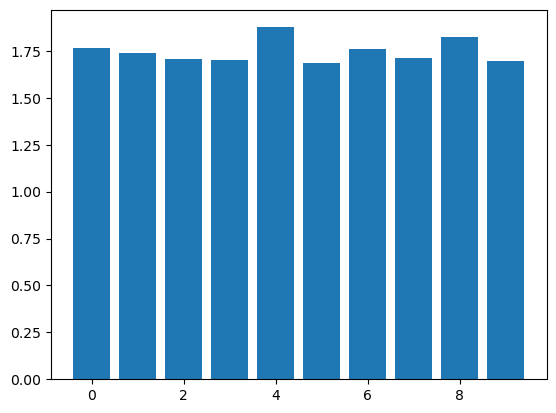

In [6]:
import matplotlib.pyplot as plt

print("Weight norm of each class part of classifier")
print(torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))).cpu().detach().numpy())

plt.show()

#  HeatMap of weight bias

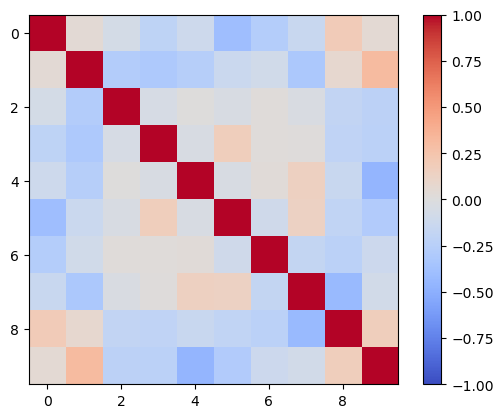

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)).cpu().detach().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

# Get a feature centroid vector and each vector's norm and cosine similarity each other (Test Data) 

In [8]:
                model.eval()
                
                label= [i for i in range(num_classes)]
                
                ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
                class_sums = {i: None for i in label}
                class_counts = {i: None for i in label}



                with torch.no_grad():
                    for idx, (images, labels) in enumerate(ldr_test):
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = model.extract_features(images)

                        for i in range(len(label)):
                            class_mask = labels == label[i]  

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                                class_features = features[class_mask]
                                class_sum = class_features.sum(dim=0)
                                count=class_features.shape[0]

                                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                    class_sums[label[i]]=class_sum
                                    class_counts[label[i]]=count
                                else:
                                    class_sums[label[i]]+=class_sum
                                    class_counts[label[i]]+=count

                #Get the class-wise feature centroid                    
                class_mean_dict={}
                for key, value in class_sums.items():
                    if key in class_counts:
                        class_mean_dict[key] = value / class_counts[key]


                #Get a inner product of centroids

                cos_sim_hist={}

                with torch.no_grad():
                    inner_product_hist={key: 0 for key in class_mean_dict.keys()}
                    for images, labels in ldr_test:
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = model.extract_features(images)
                        for i in range(len(label)):

                            mean_feature=class_mean_dict[label[i]]

                            normalized_mean_feature=mean_feature/torch.norm(mean_feature)

                            class_mask = labels == label[i]  # "cat" 클래스의 마스크를 생성합니다.

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 평균 벡터를 계산합니다.
                                class_features = features[class_mask]
                                normalized_class_features=nn.functional.normalize(class_features, p=2, dim=1)

                                inner_product=torch.mm(normalized_class_features, normalized_mean_feature.unsqueeze(1))
                                if label[i] not in cos_sim_hist.keys():
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.array([inner_product.squeeze().cpu().numpy()[()]])
                                    else:
                                        cos_sim_hist[label[i]]=inner_product.squeeze().cpu().numpy()
                                else:
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], np.array([inner_product.squeeze().cpu().numpy()[()]])), axis=0)

                                    else:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], inner_product.squeeze().cpu().numpy()), axis=0)

                                        
                cos_sim_mean={}
                cos_sim_var={}

                for key in class_sums.keys():
                    if key in class_counts:
                        cos_sim_mean[key] = cos_sim_hist[key].mean()
                        cos_sim_var[key] = cos_sim_hist[key].var()
                print("-------------------MEAN-------------------")                

                print(cos_sim_mean)
                print("-------------------VAR-------------------")                

                print(cos_sim_var)



-------------------MEAN-------------------
{0: 0.89571804, 1: 0.94370204, 2: 0.8601055, 3: 0.8344724, 4: 0.88400245, 5: 0.8683845, 6: 0.9054473, 7: 0.91438097, 8: 0.9343616, 9: 0.9315785}
-------------------VAR-------------------
{0: 0.013453064, 1: 0.010237174, 2: 0.019886723, 3: 0.016347155, 4: 0.015788576, 5: 0.018777898, 6: 0.014072917, 7: 0.015557869, 8: 0.012447835, 9: 0.012055827}


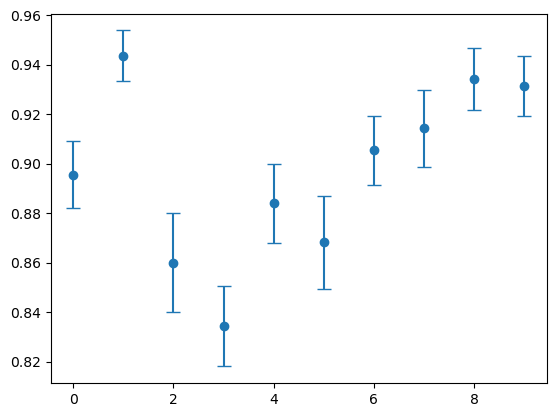

In [9]:
import matplotlib.pyplot as plt


class_index=[i for i in range(num_classes)]

#centroid로부터 cosine similarity 값들의 mean, variance
classwise_mean=list(cos_sim_mean.values())
classwise_var=list(cos_sim_var.values())

plt.errorbar(class_index, classwise_mean, classwise_var, fmt='o', capsize=5)

plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [10]:
model.eval()
label= [i for i in range(num_classes)]                    


ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
class_sums = {i: None for i in label}
class_counts = {i: None for i in label}



with torch.no_grad():
    for idx, (images, labels) in enumerate(ldr_test):
        images, labels = images.to(args.device), labels.to(args.device)
        features = model.extract_features(images)

        for i in range(len(label)):
            class_mask = labels == label[i]  

            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                class_features = features[class_mask]
                class_sum = class_features.sum(dim=0)
                count=class_features.shape[0]

                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                    class_sums[label[i]]=class_sum
                    class_counts[label[i]]=count
                else:
                    class_sums[label[i]]+=class_sum
                    class_counts[label[i]]+=count

#Get the class-wise feature centroid                    
class_mean_dict={}
for key, value in class_sums.items():
    if key in class_counts:
        class_mean_dict[key] = value / class_counts[key]

print(class_mean_dict)
#Get a Inner product of each class's centroid vector

sorted_keys=sorted(class_mean_dict)
print(sorted_keys)

class_mean_lst=[]


for key in sorted_keys:
    class_mean_lst.append(class_mean_dict[key])

class_mean_lst=torch.stack(class_mean_lst)


print(class_mean_lst.shape)
print(class_mean_lst.transpose(0,1).shape)

#Get the each centroid vector's norm
print("-------------Norm of each centroid vectors --------------")
print(torch.diagonal(torch.mm(class_mean_lst, class_mean_lst.transpose(0,1))))


#Get the cosine similarity result between eacn centroid vectors


normalized_class_mean_lst=nn.functional.normalize(class_mean_lst, p=2, dim=1)
print("-------------Cosine similarity of Each Centroid vectors--------------")
print(torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy())

                    
    


{0: tensor([9.3781e-01, 3.7302e-01, 7.6904e-01, 3.4544e-02, 3.2939e-01, 3.3940e-04,
        9.3504e-01, 1.2119e+00, 1.9103e+00, 4.2349e-04, 9.1296e-02, 4.4700e-02,
        4.0342e-01, 4.8701e-01, 3.5000e-02, 5.1436e-01, 1.3884e+00, 6.3842e-01,
        3.6063e-01, 3.9692e-01, 2.8016e-01, 7.3522e-01, 2.7389e-01, 3.6185e-01,
        5.3451e-01, 3.4745e-01, 6.8793e-01, 1.5490e+00, 7.2239e-01, 5.2632e-02,
        1.8770e-02, 3.9506e-02, 1.5659e+00, 4.4903e-01, 7.0081e-02, 1.8204e-01,
        4.2234e-04, 9.0645e-05, 1.5380e-02, 6.0348e-01, 2.1542e+00, 0.0000e+00,
        1.9034e-04, 4.0276e-01, 1.1700e-01, 8.9699e-01, 5.7046e-01, 4.6418e-01,
        1.1085e-01, 3.9032e-01, 7.8529e-02, 7.6853e-01, 2.5299e-01, 2.8480e-01,
        1.2000e+00, 7.7137e-04, 7.7715e-01, 5.3876e-01, 4.2204e-01, 1.0853e-01,
        1.5534e+00, 5.3890e-02, 0.0000e+00, 6.7430e-02, 3.8864e-02, 3.7982e-02,
        5.7322e-01, 0.0000e+00, 4.6438e-02, 1.1897e-01, 3.7107e-01, 6.1162e-02,
        8.5185e-04, 4.3885e-02, 1.69

# Cosine Similarity of Centroid Vectors

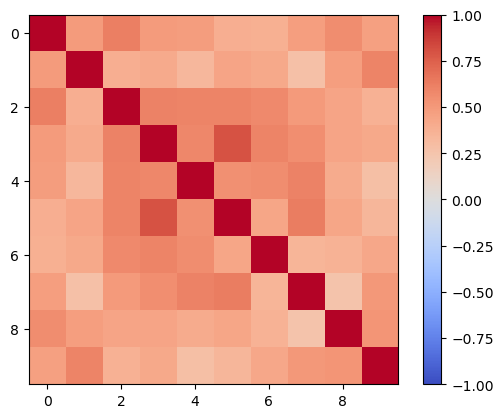

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [12]:
print(type(cos_sim_np))

print(cos_sim_np)

print(cos_sim_np.sum(axis=1))

print(cos_sim_np.sum(axis=0))

<class 'numpy.ndarray'>
[[1.         0.48859322 0.62055993 0.48504835 0.48152155 0.38622543
  0.37879896 0.47302583 0.55598646 0.46664232]
 [0.48859322 1.         0.3892418  0.41018808 0.33305717 0.44159114
  0.42091575 0.27962378 0.47147235 0.5967767 ]
 [0.62055993 0.3892418  1.         0.6075729  0.5965527  0.5953944
  0.5759003  0.49260938 0.43953705 0.36757237]
 [0.48504835 0.41018808 0.6075729  0.99999994 0.58506083 0.7991492
  0.5939803  0.5479224  0.43877882 0.41713813]
 [0.48152155 0.33305717 0.5965527  0.58506083 0.9999999  0.54564416
  0.56051564 0.603309   0.40338185 0.28633934]
 [0.38622543 0.44159114 0.5953944  0.7991492  0.54564416 1.
  0.43187726 0.62732136 0.43170136 0.34134525]
 [0.37879896 0.42091575 0.5759003  0.5939803  0.56051564 0.43187726
  1.         0.35107508 0.36242616 0.42667362]
 [0.47302583 0.27962378 0.49260938 0.5479224  0.603309   0.62732136
  0.35107508 1.         0.25232118 0.5012887 ]
 [0.55598646 0.47147235 0.43953705 0.43877882 0.40338185 0.4317013

# Centroid-Feature Alignment

In [13]:
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

tensor([0.6370, 0.6703, 0.6242, 0.5591, 0.5934, 0.6381, 0.6102, 0.6243, 0.6167,
        0.6544], device='cuda:6', grad_fn=<DiagonalBackward0>)


Centroid-Feature Alignment of each class
tensor([0.6370, 0.6703, 0.6242, 0.5591, 0.5934, 0.6381, 0.6102, 0.6243, 0.6167,
        0.6544], device='cuda:6', grad_fn=<DiagonalBackward0>)


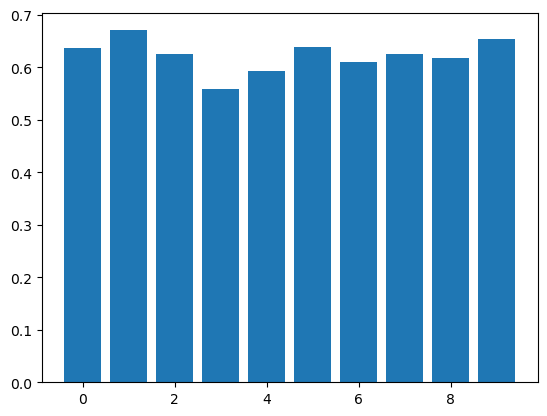

In [14]:
import matplotlib.pyplot as plt

print("Centroid-Feature Alignment of each class")
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))).cpu().detach().numpy())

plt.show()

# Gihun(FedNTD)

In [15]:
    model_key = [name for name, p in model.named_parameters()]
    print(model_key)

['features.0.weight', 'features.0.bias', 'features.3.weight', 'features.3.bias', 'features.6.weight', 'features.6.bias', 'features.8.weight', 'features.8.bias', 'features.11.weight', 'features.11.bias', 'features.13.weight', 'features.13.bias', 'features.16.weight', 'features.16.bias', 'features.18.weight', 'features.18.bias', 'fc.0.weight', 'fc.0.bias', 'fc.2.weight', 'fc.2.bias', 'classifier.weight', 'classifier.bias']


In [16]:
    info_param = [p for name, p in model.named_parameters() if 'fc.2.weight' in name]

    #Get the innerproduct of the classifier part

    print(info_param[0].shape)
    print(len(info_param))


torch.Size([512, 512])
1


In [17]:
print(class_mean_dict[0].shape)

torch.Size([512])


In [18]:
print(torch.transpose(info_param[0], 0, 1)[0].shape)

torch.Size([512])


In [19]:
print(torch.transpose(info_param[0], 0, 1).shape)

torch.Size([512, 512])


In [20]:
list_storage=[]


print(torch.matmul(torch.transpose(info_param[0], 0, 1), class_mean_dict[0]))
print(torch.matmul(torch.transpose(info_param[0], 0, 1), class_mean_dict[0]).shape)


for index in range(10):

    class_info=torch.matmul(torch.transpose(info_param[0], 0, 1), class_mean_dict[index])

    list_storage.append(class_info)
    
print(len(list_storage))    

print(list_storage[0].size())
final= torch.stack((list_storage[0], list_storage[1], list_storage[2], list_storage[3], list_storage[4], list_storage[5], list_storage[6], list_storage[7], list_storage[8], list_storage[9]), dim=0)    


print(final)

print(final.shape)


# 각 행에서 최댓값을 가진 행의 인덱스 추출
max_indices = torch.argmax(final, dim=0).to('cpu').numpy()

print(max_indices)
print(len(max_indices))

tensor([-2.9366e-01, -2.1133e-01,  3.5081e-01, -4.2474e-01, -3.1689e-02,
        -3.5292e-01,  2.0177e-01, -2.6464e+00,  1.8473e-01, -5.4731e-01,
         6.8739e-01, -1.3835e-01, -8.4356e-01, -4.7975e-01,  2.0762e+00,
         8.4803e-01,  1.4883e+00, -5.4701e-01,  1.1362e-01,  3.9272e-01,
         1.1442e+00, -1.1234e-01, -8.1023e-01,  5.0148e-01, -1.0249e-01,
        -2.1805e-01, -6.6240e-01,  7.0569e-01, -1.4316e-01, -4.3946e-01,
        -2.2170e-03, -1.1949e-01,  1.4089e+00,  1.7071e-01,  1.2491e+00,
         7.5884e-01, -1.3785e-01,  3.9802e-01, -1.6470e-02, -1.2236e+00,
         1.3857e+00,  5.6049e-02, -1.8085e-01,  2.6475e-01,  4.6525e-01,
        -4.6313e-01, -2.1242e-01, -1.2474e+00,  4.5449e-01,  3.2770e-01,
        -4.3553e-02, -2.5600e-01,  3.0956e-02, -5.9184e-01,  1.1020e+00,
         1.1064e-01,  1.9821e+00, -1.1644e-01, -1.3738e+00,  1.3536e+00,
         9.3544e-02,  1.8366e+00, -4.0311e-01, -6.1763e-01, -2.5290e-02,
         1.3772e-01,  5.8258e-01,  3.8053e-01, -4.8

파이썬의 Matplotlib 라이브러리를 사용하여 10개의 구분 잘되는 색을 추천해 드릴 수 있습니다. 다음은 추천하는 색상 목록입니다:

#1f77b4 (파란색)
#ff7f0e (주황색)
#2ca02c (녹색)
#d62728 (빨간색)
#9467bd (보라색)
#8c564b (갈색)
#e377c2 (분홍색)
#7f7f7f (회색)
#bcbd22 (옐로우)
#17becf (청록색)

In [21]:
color_dict={0: "#1f77b4", 1: "#ff7f0e", 2: "#2ca02c", 3:"#d62728", 4: "#9467bd", 5: "#8c564b", 6: "#e377c2", 7: "#7f7f7f", 8: "#bcbd22", 9: "#17becf" }

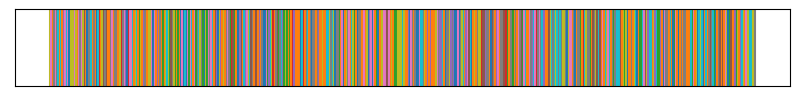

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 1))

for i in range(len(max_indices)):
    plt.plot((i, i), (0, 1), scaley=False, color=color_dict[max_indices[i].item()])

plt.xticks([])  # x축 눈금 숨김
plt.yticks([])  # y축 눈금 숨김

# 그래프를 저장할 디렉토리 경로 설정
save_dir = 'Analysis_figure/ntd/iid/full/'

# 그래프 저장
plt.savefig(save_dir + 'DG_default.png')


plt.show()


In [23]:
def find_permutation(lst):
    sorted_indices = sorted(range(len(lst)), key=lambda x: lst[x])
    return sorted_indices

In [24]:
permutation_func = find_permutation(max_indices)
print(permutation_func)

permuted_max_indices= [max_indices[i] for i in permutation_func]

[14, 27, 34, 56, 75, 95, 97, 99, 112, 122, 136, 137, 155, 156, 182, 190, 207, 213, 223, 231, 234, 238, 261, 266, 267, 287, 294, 295, 297, 306, 320, 375, 381, 419, 426, 445, 452, 456, 470, 474, 483, 492, 2, 7, 9, 20, 26, 31, 33, 37, 42, 43, 46, 49, 50, 61, 64, 67, 70, 71, 77, 79, 81, 83, 92, 94, 104, 119, 125, 127, 135, 140, 148, 151, 153, 163, 173, 175, 178, 179, 180, 181, 185, 188, 193, 196, 197, 199, 200, 211, 214, 218, 222, 226, 227, 229, 236, 239, 240, 247, 249, 258, 259, 264, 273, 275, 277, 278, 279, 286, 301, 307, 309, 319, 323, 326, 333, 337, 339, 346, 347, 360, 361, 379, 382, 386, 393, 400, 402, 407, 415, 420, 421, 423, 427, 437, 444, 449, 451, 455, 457, 459, 462, 463, 464, 468, 475, 477, 484, 487, 489, 495, 496, 500, 504, 65, 82, 87, 91, 93, 101, 106, 111, 114, 131, 134, 158, 166, 170, 172, 174, 210, 221, 237, 250, 251, 332, 336, 343, 385, 392, 409, 417, 428, 429, 441, 442, 453, 466, 482, 493, 498, 36, 52, 57, 132, 162, 176, 184, 313, 331, 353, 387, 10, 55, 68, 78, 121, 124, 1

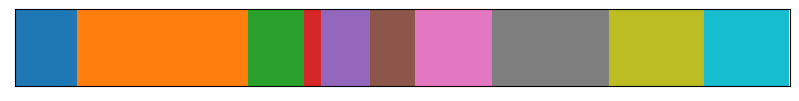

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 1))

for i in range(len(max_indices)):
    plt.plot((i, i), (0, 1), scaley=False, color=color_dict[permuted_max_indices[i].item()])
plt.xlim(0, len(max_indices))
plt.xticks([])  # x축 눈금 숨김
plt.yticks([])  # y축 눈금 숨김

# 그래프를 저장할 디렉토리 경로 설정
save_dir = 'Analysis_figure/ntd/iid/full/'

# 그래프 저장
plt.savefig(save_dir + 'DG.png')


plt.show()


# Generate Local Model

In [26]:
def get_class_mean_dict(model, num_classes, dataset_test, args):

    model.eval()
    label= [i for i in range(num_classes)]                    


    ldr_test = DataLoader(dataset_test, batch_size=args.bs, shuffle=False)
    class_sums = {i: None for i in label}
    class_counts = {i: None for i in label}



    with torch.no_grad():
        for idx, (images, labels) in enumerate(ldr_test):
            images, labels = images.to(args.device), labels.to(args.device)
            features = model.extract_features(images)

            for i in range(len(label)):
                class_mask = labels == label[i]  

                if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                    class_features = features[class_mask]
                    class_sum = class_features.sum(dim=0)
                    count=class_features.shape[0]

                    if class_sums[label[i]]== None and class_counts[label[i]] == None:
                        class_sums[label[i]]=class_sum
                        class_counts[label[i]]=count
                    else:
                        class_sums[label[i]]+=class_sum
                        class_counts[label[i]]+=count

    #Get the class-wise feature centroid                    
    class_mean_dict={}
    for key, value in class_sums.items():
        if key in class_counts:
            class_mean_dict[key] = value / class_counts[key]
            
    return class_mean_dict


In [27]:
def get_local_figure(info_param, class_mean_dict, local_index):

    list_storage=[]



    for index in range(10):

        class_info=torch.matmul(torch.transpose(info_param[0], 0, 1), class_mean_dict[index])

        list_storage.append(class_info)


    final= torch.stack((list_storage[0], list_storage[1], list_storage[2], list_storage[3], list_storage[4], list_storage[5], list_storage[6], list_storage[7], list_storage[8], list_storage[9]), dim=0)    

    # 각 행에서 최댓값을 가진 행의 인덱스 추출
    max_indices = torch.argmax(final, dim=0).to('cpu').numpy()

    permuted_max_indices= [max_indices[i] for i in permutation_func]


    if local_index%10==0:
        plt.figure(figsize=(10, 1))

        for i in range(len(max_indices)):
            plt.plot((i, i), (0, 1), scaley=False, color=color_dict[permuted_max_indices[i].item()])
        plt.xlim(0, len(max_indices))
        plt.xticks([])  # x축 눈금 숨김
        plt.yticks([])  # y축 눈금 숨김

        # 그래프를 저장할 디렉토리 경로 설정
        save_dir = 'Analysis_figure/ntd/iid/full/'

        # 그래프 저장
        plt.savefig(save_dir + 'Local_{}.png'.format(local_index))


In [28]:
def get_aggregated_figure(info_param, class_mean_dict):

    list_storage=[]



    for index in range(10):

        class_info=torch.matmul(torch.transpose(info_param[0], 0, 1), class_mean_dict[index])

        list_storage.append(class_info)


    final= torch.stack((list_storage[0], list_storage[1], list_storage[2], list_storage[3], list_storage[4], list_storage[5], list_storage[6], list_storage[7], list_storage[8], list_storage[9]), dim=0)    

    # 각 행에서 최댓값을 가진 행의 인덱스 추출
    max_indices = torch.argmax(final, dim=0).to('cpu').numpy()

    permuted_max_indices= [max_indices[i] for i in permutation_func]


     
    plt.figure(figsize=(10, 1))

    for i in range(len(max_indices)):
        plt.plot((i, i), (0, 1), scaley=False, color=color_dict[permuted_max_indices[i].item()])
    plt.xlim(0, len(max_indices))
    plt.xticks([])  # x축 눈금 숨김
    plt.yticks([])  # y축 눈금 숨김

    # 그래프를 저장할 디렉토리 경로 설정
    save_dir = 'Analysis_figure/ntd/iid/full/'

    # 그래프 저장
    plt.savefig(save_dir + 'AG.png')


Files already downloaded and verified
Files already downloaded and verified
-----------------------------------------------------
Client: 0
84.0
After
85.0
-----------------------------------------------------
Client: 1
81.0
After
79.0
-----------------------------------------------------
Client: 2
85.0
After
85.0
-----------------------------------------------------
Client: 3
81.0
After
81.0
-----------------------------------------------------
Client: 4
82.0
After
80.0
-----------------------------------------------------
Client: 5
82.0
After
82.0
-----------------------------------------------------
Client: 6
88.0
After
88.0
-----------------------------------------------------
Client: 7
83.0
After
83.0
-----------------------------------------------------
Client: 8
79.0
After
79.0
-----------------------------------------------------
Client: 9
84.0
After
86.0
-----------------------------------------------------
Client: 10
78.0
After
78.0
-------------------------------------------

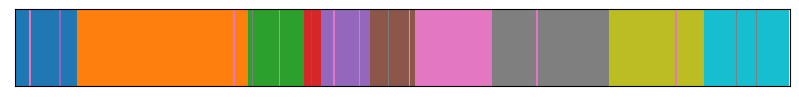

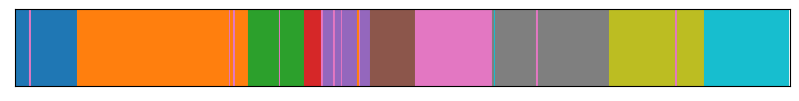

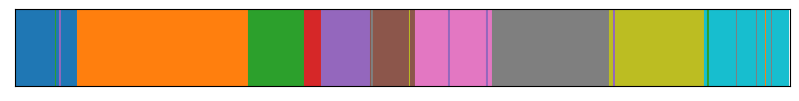

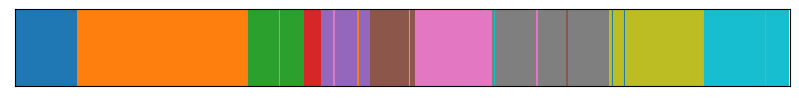

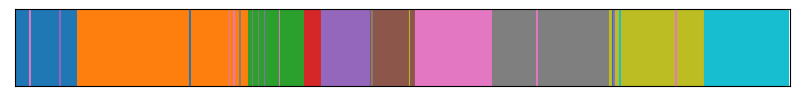

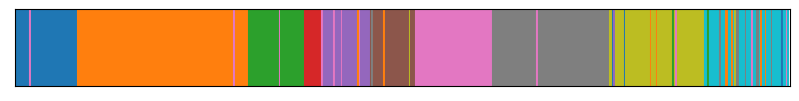

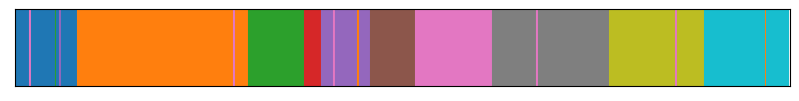

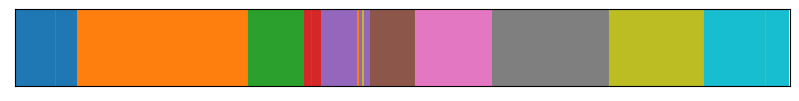

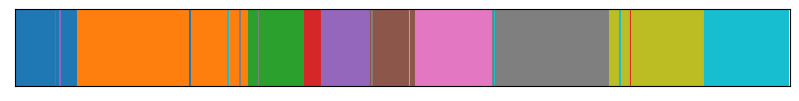

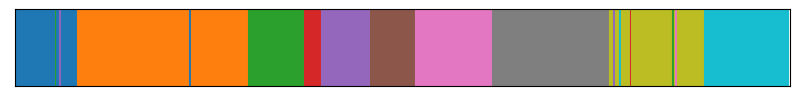

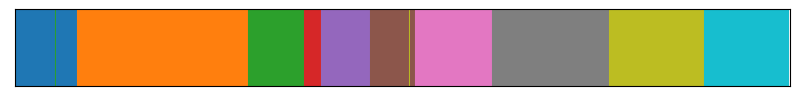

In [29]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for frac in [0.1]:
    for local_ep in [15]:
        for local_upt_part, aggr_part in [('full', 'full')]:
            args = easydict.EasyDict({'epochs': local_ep,
                                      'num_users': 100,
                                      'server_data_ratio': server_data_ratio,
                                      'frac': frac,
                                      'local_ep': local_ep,
                                      'local_bs': 500,
                                      'bs': 50,
                                      'lr': 0.01,
                                      'momentum': momentum,
                                      'wd': wd,
                                      'model': model,


                                      'dataset': dataset,
                                      'iid': True,
                                      'num_classes': num_classes,
                                      'gpu': 6,
                                      'verbose': False,
                                      'seed': 1,
                                      'test_freq': 1,
                                      'load_fed': '',
                                      'results_save': 'run1',
                                      'local_upt_part': local_upt_part,
                                      'aggr_part': aggr_part,
                                      'feature_norm': 1,
                                      'fn': False
                                      })

            # parse args
            args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
            base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd, args.fn)
            algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)


            dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
            dict_save_path = 'dict_users_10.pkl'
            with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                dict_users_train, dict_users_test = pickle.load(handle)

            # build model
            net_glob = get_model(args)
            net_glob.train()

            net_local_list = []
            for user_ix in range(args.num_users):
                net_local_list.append(copy.deepcopy(net_glob))

            criterion = nn.CrossEntropyLoss()

            before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
            after_acc_results = []
            
            w_glob = None
            data_size=[]

            for user, net_local in enumerate(net_local_list):
                model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                before_acc_results.append(acc_test)
                
                print ("-----------------------------------------------------")
                print ("Client: {}".format(user))
                
                print(acc_test)
                
                net_local.train()
                ldr_train = DataLoader(DatasetSplit(dataset_train, dict_users_train[user]), batch_size=args.bs, shuffle=True)
                
                body_params = [p for name, p in net_local.named_parameters() if 'classifier' not in name]
                head_params = [p for name, p in net_local.named_parameters() if 'classifier' in name]
                optimizer = torch.optim.SGD([{'params': body_params, 'lr': 0.0001},
                                             {'params': head_params, 'lr': 0.0001}],
                                            momentum=args.momentum, weight_decay=args.wd)#full update!!

                for iter in range(args.local_ep):
                    for batch_idx, (images, labels) in enumerate(ldr_train):
                        images, labels = images.to(args.device), labels.to(args.device)
                        net_local.zero_grad()
                        logits = net_local(images)

                        loss = criterion(logits, labels)
                        loss.backward()
                        optimizer.step()

                acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                after_acc_results.append(acc_test)#pretrain 이후의 personalized accuracy 기재!!
                print('After')
                print(acc_test)
                
                
                #Get a Local Model figure
                
                class_mean_dict=get_class_mean_dict(net_local, num_classes, dataset_test, args)
                info_param = [p for name, p in net_local.named_parameters() if 'fc.2.weight' in name]
                 
                get_local_figure(info_param, class_mean_dict, user)
                
                
                train_size=len(dict_users_train[user])
                
                data_size.append(train_size)
                
                if w_glob is None:
                    w_glob = copy.deepcopy(net_local.state_dict())
                else:
                    for k in w_glob.keys():
                        w_glob[k] += net_local.state_dict()[k]

            # Aggregation
            for k in w_glob.keys():
                w_glob[k] = torch.div(w_glob[k], args.num_users)
                
            agg_net= get_model(args)   
            
            agg_net.load_state_dict(w_glob)    
            class_mean_dict=get_class_mean_dict(agg_net, num_classes, dataset_test, args)
            info_param = [p for name, p in agg_net.named_parameters() if 'fc.2.weight' in name]

                
                
            get_aggregated_figure(info_param, class_mean_dict)                
            agg_accuracy, agg_test_loss =test_img_global(agg_net, dataset_test, args)
            print ("-----------------------------------------------------")
            print ("local update part: {}, aggregation part: {}".format(local_upt_part, aggr_part))
            print ("iid, frac: {}, local_ep: {}".format(frac, local_ep))
            print ("Before min/max/mean/std of accuracy")
            print (np.min(before_acc_results), np.max(before_acc_results), np.mean(before_acc_results), round(np.std(before_acc_results), 2))
            print ("After min/max/mean/std of accuracy")
            print (np.min(after_acc_results), np.max(after_acc_results), np.mean(after_acc_results), round(np.std(after_acc_results), 2))
            print ("-----------------------------------------------------")
            
            print ("Accuracy of Aggregated Model")
            print (agg_accuracy)
            print ("-----------------------------------------------------")            